### `Survey` Tutorial

This tutorial intoduces reader to `Survey` class, a lightweigh wrapper which provides access to SEG-Y headers and means to load various seismic gathers. <br>
The notebook leads through `Survey` initialization and highlights its' most useful attributes and methods. <br>

### Table Of Contents

[SEG-Y format](#SEG-Y-format) <br>
[Introduction](#Introduction) <br>
[Attributes](#Attributes) <br>
[Methods](#Methods) <br>
[Creating Gather](#Creating-Gather) <br>
[Conclusion](#Conclusion) <br>

In [1]:
import sys # delete after finish
sys.path.append('..') # delete after finish

import matplotlib.pyplot as plt

from seismicpro import Survey, make_prestack_segy, trace_generator

### SEG-Y format

Since `Survey`  is a concise image of the SEG-Y file, it is useful to refresh the memory of its' format. It consists of three main blocks:<br>
- File Header with general information about the seismic survey.
- Trace Headers that contain information about each trace.
- Trace Data with recorded signal.

Scheme of SEG-Y format of revision 2 <br>
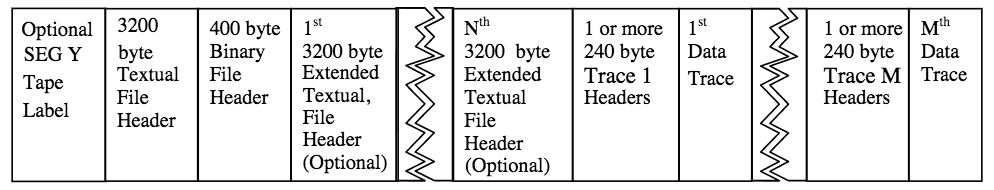

`Survey` stores a part of general data from File Header and specific fields from Trace Headers for each trace. It does not store any Trace Data, but can load it and put in a generated instance of [`Gather`](TODO) class. This allows to keep memory footprint of `Survey` to a minimum.

### Introduciton

For convenience, this tutorial uses SEG-Y file with sythetic data that is going to be generated in the following line.

In [2]:
sgy_path = './data/synthetic_survey.sgy'
make_prestack_segy(sgy_path, survey_size=(1500,1500), activation_dist=(1500,1500), trace_gen=trace_generator)

  0%|          | 0/150 [00:00<?, ?it/s]

To create a survey one needs to provide a path to the SEG-Y file and specify trace headers to load:

In [3]:
survey = Survey(sgy_path, header_index='FieldRecord', header_cols='offset')

`Survey` objects store loaded trace headers as `pandas.Dataframe` named `headers`. <br>
`header_index` is a trace header or a list of trace headers that is going to be used as an index of the `headers` dataframe. Its value is also used to group traces to obtain and load seismic gathers.<br>
`header_cols` define other trace headers one needs to load.

[Trace headers keys](https://segyio.readthedocs.io/en/latest/segyio.html#constants) section in documentation of `segyio` library describes all available trace headers.<br>

To see summary about the SEG-Y file, one can call `info()` method of the initialized object: <br>

In [4]:
survey.info()


Survey path:               ./data/synthetic_survey.sgy
Survey name:               synthetic_survey
Survey size:               0.785 GB
Number of traces:          135000
Traces length:             1500 samples
Sample rate:               2.0 ms
Offsets range:             [0 m, 2068 m]

Index name(s):             FieldRecord
Number of unique indices:  150



The `Survey name` SEG-Y file is located at the `Survey path` and takes `Survey size` space on the disk. It contains `Number of traces` traces, each of which has `Traces length` samples collected with `Sample rate` time interval. The offsets of those traces vary in `Offsets range`. <br>

`headers` dataframe is indexed with `Index name(s)`, and it contains `Number of unique indices` unique values.

In this example `survey` is indexed with `FieldRecord` trace header - the one that describes sources. Since `Survey` generates gathers by groupping traces with same value of `header_index`, all the gather from `survey` object are going to be common shot gathers. Below you can see a table that describes which trace header indices correspond to most commonly used gathers:

In [5]:
%%html
# нужно для корретного расположения таблицы по левому краю. убрать при заврешении
<style>
table {float:left}
</style>

| Gather type | header_index |
| :- | -: |
| Common-shot gather | `FieldRecord` |
| Common-midpoint gather | `CDP` / `[INLINE_3D, CROSSLINE_3D]`|
| Common-receiver gather | `[GroupX, GroupY]` |
| Common-offset section | `offset` |

### Attributes

Here are the most useful attributes of the Survey class.

<b>`headers`</b> - `pandas.Dataframe` containing the trace headers specified at the instantiation of `Survey` object. <br>

In [6]:
survey.headers

,offset,TRACE_SEQUENCE_FILE
FieldRecord,,
0,0,1
0,25,2
0,50,3
0,75,4
0,100,5
...,...,...
149,182,134996
149,206,134997
149,230,134998


`headers` Dataframe indexed by `FieldRecord` and containing `offset` values for each trace.<br>
`TRACE_SEQUENCE_FILE` represents unique index of each trace in the SEG-Y file and is added to `headers` automatically upon Survey creation.

<b>`sample_rate` </b> - sample interval for each trace in milliseconds

In [7]:
survey.sample_rate

2.0

<b>`samples_length` </b> - number of samples for each trace. <br>
It is required that all traces in the SEG-Y file have the same sample_length.

In [8]:
survey.samples_length

1500

<b>`samples`</b> - array of record timestamps in milliseconds<br>
An array that usually starts at 0 and is incremented with `sample_rate` for the `samples_length` times.

In [9]:
survey.samples

array([0.000e+00, 2.000e+00, 4.000e+00, ..., 2.994e+03, 2.996e+03,
       2.998e+03], dtype=float32)

### Methods

<b>`filter()` </b>

This method returns a new `Survey` object with a subset of original traces that satisfies given condition.

`Survey.filter` expects a condition given as a callable and names of columns from `headers` which will be passed to the condition. <br>
This example shows how to select traces with `offset` less than 100 meters:

In [10]:
filtered_survey = survey.filter(cond=lambda x: x < 100, cols='offset')
filtered_survey.info()


Survey path:               ./data/synthetic_survey.sgy
Survey name:               synthetic_survey
Survey size:               0.785 GB
Number of traces:          1408
Traces length:             1500 samples
Sample rate:               2.0 ms
Offsets range:             [0 m, 90 m]

Index name(s):             FieldRecord
Number of unique indices:  150



Resulting `filtered_survey` contains less traces than the original one, and its offsets are all less than 100 m.

<b>`apply()` </b>

It applies a function to `headers` values.

`Survey.apply` expects a callable and names of columns from `headers` to apply function to. <br>
In example below `offset` is increased by a factor of two and the result is stored in a new columns specified by `res_cols` argument. <br>

In [11]:
applied_survey = survey.apply(func=lambda x: x * 2, cols='offset', res_cols='offset_x2')
applied_survey.headers

,offset,TRACE_SEQUENCE_FILE,offset_x2
FieldRecord,,,
0,0,1,0
0,25,2,50
0,50,3,100
0,75,4,150
0,100,5,200
...,...,...,...
149,182,134996,364
149,206,134997,412
149,230,134998,460


Now `headers` contains new 'offset_x2' column with doubled offsets.<br>

<b>`collect_stats()`</b>

`collect_stats` is used to calculate the traces' statistics and store this information in `Survey`.

In [12]:
survey.collect_stats()

Calculating statistics for survey synthetic_survey:   0%|          | 0/135000 [00:00<?, ?it/s]

One can achieve the same result by creating a `Survey` object with flag `collect_stats=True` <br>
For example: <br>


```python
survey_with_stats = Survey(sgy_path, header_index='FieldRecord', header_cols='offset', collect_stats=True)
```


In [13]:
survey.info()


Survey path:               ./data/synthetic_survey.sgy
Survey name:               synthetic_survey
Survey size:               0.785 GB
Number of traces:          135000
Traces length:             1500 samples
Sample rate:               2.0 ms
Offsets range:             [0 m, 2068 m]

Index name(s):             FieldRecord
Number of unique indices:  150

Survey statistics:
Number of dead traces:     0
Trace limits:              0:1500:1 samples
mean | std:                      0.00 | 0.33      
 min | max:                     -4.73 | 3.23      
 q01 | q99:                     -0.93 | 1.46      



Now `survey.info()` has a new `Survey statistics` block.

These statistics allow to preform normalization and standardization of the data, which is quite useful for many machine learning tasks.<br>

In case one trains a model not on the whole trace, but on the data from a specific time window, normalization/standardization should be carried out using statistics calculated in that exact time window.<br>
`Survey` provides this option using `stats_limit` parameter, measured in ms, upon instantiation
```python
survey_with_limits = Survey(sgy_path, header_index='FieldRecord', header_cols='offset', collect_stats=True, stats_limits=(0, 1000))
```
or `limits` parameter in `collect_stats()` method:
```python
survey_with_limits = survey.collect_stats(limits=(0,1000))
```

### Creating Gather

`Survey` objects do not store seismic data, but they have two methods that allow one to generate `Gather` objects with trace data: `sample_gather` and `get_gather`.

<b>`get_gather()`</b>

`get_gather` expects an index value from `header_index` and returns a `Gather` object with all the traces with this index value:<br>
```python
gather = survey.get_gather(some_index)
```

<b>`sample_gather()`</b>

`sample_gather` does the same, but it randomly selects an index value from `header_index`. <br>

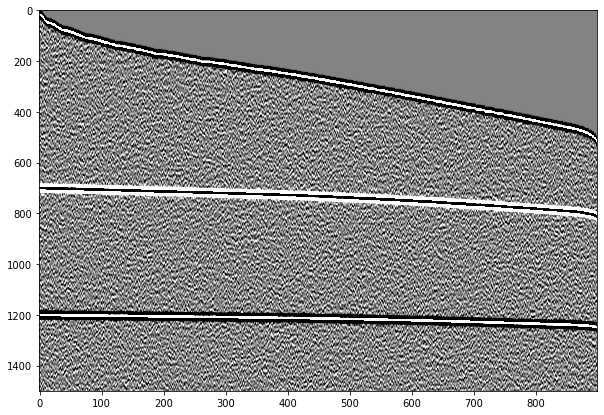

In [14]:
gather = survey.sample_gather().sort(by='offset') # delete sort after finish
gather.plot()

Read more about `Gather` in [this tutorial]().

### Conclusion

This tutorial
* explaied the purpose of `Survey` class and showed a process of its instantiation
* described `Survey`'s principal attributes with examples of their contents
* listed `Survey`'s most importand methods with illustrations of their calls

To learn more please refer to the [documentation]().

[Go to top](#Survey-Tutorial)